In [ ]:
# Required Packages
!pip install --upgrade --quiet huggingface_hub transformers bitsandbytes accelerate tqdm langchain langchain_community chromadb sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 3.7 MB/s eta 0:00:00


In [ ]:
# Imports
import glob
from tqdm import tqdm
import requests
from PIL import Image
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Load Image to Text Model
model_id = "llava-hf/bakLlava-v1-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    load_in_4bit=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Load Pre-Processor based on Model ID
processor = AutoProcessor.from_pretrained(model_id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Load and Define Embedding Model
model_name = "BAAI/bge-large-en-v1.5"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embedding_model = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

In [ ]:
# Caption Generation Prompt
prompt = "USER: <image>\ndescribe this image and make sure to include anything notable about it (include text you see in the image)\nASSISTANT:"

In [ ]:
# Iterate over each image from folder and generate captions
images_caption_dictionary = []
# Get list of all the image files in the referenced folder
image_files_paths = glob.glob(f"images/*.jpeg")
image_files_paths += glob.glob(f"images/*.jpg")
if image_files_paths != None and len(image_files_paths) > 0:
  for image_file_path in tqdm(image_files_paths):
      # Open the Image file and convert to Base64 array
      with Image.open(image_file_path) as img:
        inputs = processor(prompt, img, return_tensors='pt').to(0, torch.float16)
        output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
        images_caption_dictionary.append({
            "image_path": image_file_path,
            "caption": processor.decode(output[0][2:], skip_special_tokens=True).split('ASSISTANT:')[1]
        })

100%|██████████| 2/2 [00:26<00:00, 13.37s/it]


In [ ]:
# Index Captions to vector store and add file path as metadata
vector_db = Chroma.from_texts([item['caption'].strip() for item in images_caption_dictionary],
                                    metadatas=[{'image_path': item['image_path'].strip()} for item in images_caption_dictionary],
                                    embedding=embedding_model,
                                    persist_directory="./chroma_db")
retriever = vector_db.as_retriever(search_kwargs={"k": 1})

In [ ]:
# Method to search and display relevant images
def search_images(query, retriever):
  results = retriever.get_relevant_documents(query)
  for result_item in results:
      print(result_item)
      # Display Images as result
      image = cv2.imread(result_item.metadata['image_path'])[:,:,::-1]
      plt.imshow(image)
      plt.show()

page_content="The image features a tan dog sitting in the back of a car, licking its lips and enjoying the ride. The dog is wearing a vest, indicating that it may be a service or working dog. The car's interior is visible, with a seat in the foreground and another in the background. There is also a person partially visible near the top left corner of the image." metadata={'image_path': 'images/Bingo.jpg'}


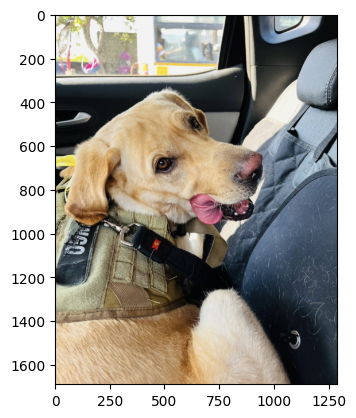

In [ ]:
# Search Images
search_images('dog', retriever)